In [1]:
# initial dataframe from the cleaned data in silver layer
import pandas as pd
from pathlib import Path

silver_path = Path.cwd().parent / 'data' / 'silver' / 'creditcard_fraud_cleaned.parquet'

df = pd.read_parquet(silver_path)
print(df.shape)
df.head(3)

(283726, 31)


,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [2]:
# splitting dataset in X(independent features) and y (target class)

X = df.drop(columns='class')
y = df['class']
(y.value_counts()/y.shape[0])*100

class
0    99.83329
1     0.16671
Name: count, dtype: float64

In [3]:
# all the dataset is already scaled with pca transform, except for time and amount
# so before splitting and training the dataset,let's scale:
# time using minMaxscaler, which is standard
# amount using robustScaler, to better treat the significant rigth skewness and outliers

from sklearn.preprocessing import MinMaxScaler, RobustScaler
time_scaler = MinMaxScaler()
amount_scaler = RobustScaler()
X['time_scaled'] = time_scaler.fit_transform(X[['time']])
X['amount_scaled'] =amount_scaler.fit_transform(X[['amount']])
X[['amount_scaled','time_scaled']].describe()

,amount_scaled,time_scaled
count,283726.000000,283726.000000
mean,0.924387,0.548701
std,3.482123,0.274787
min,-0.305938,0.000000
25%,-0.228063,0.313699
50%,0.000000,0.490141
75%,0.771937,0.806160
max,356.962314,1.000000


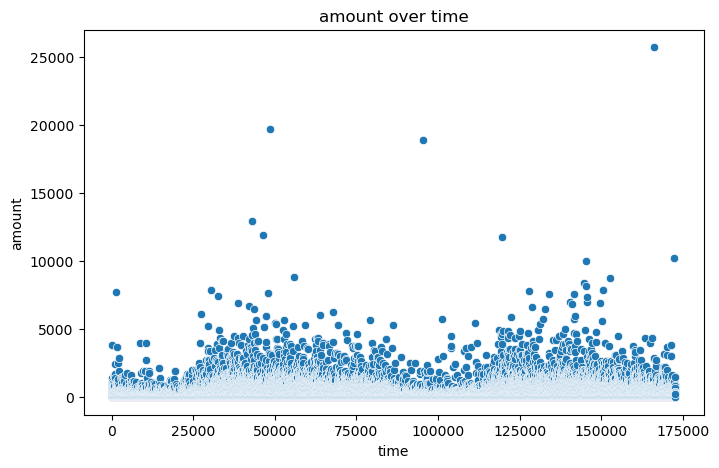

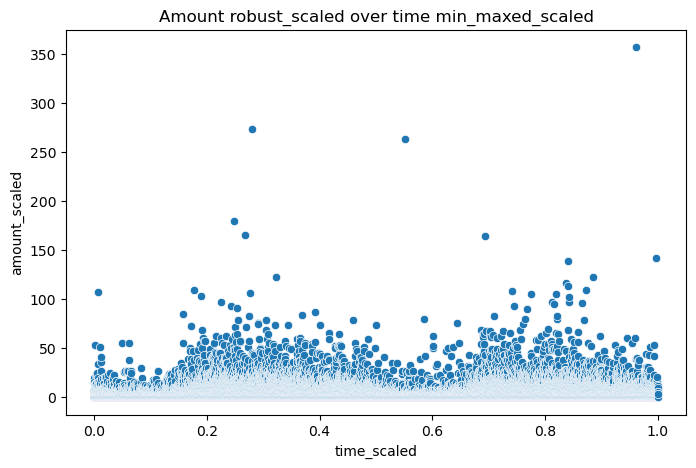

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,5))
sns.scatterplot(data = X, x='time', y='amount')
plt.title('amount over time')
plt.show()
plt.figure(figsize=(8,5))
sns.scatterplot(data = X, x='time_scaled', y='amount_scaled')
plt.title('Amount robust_scaled over time min_maxed_scaled')
plt.show()


In [24]:
# splitting the data in training and testing, using stratify to keep the proportions and not bias the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y)

In [11]:
# lets check the data splitting (this could be a function in the ML pipeline) (still simillar proportion)
print('how many frauds and non frauds in the test split\n',y_train.value_counts())
print()
print((y_train.value_counts()/y_train.shape[0])*100)

how many frauds and non frauds in the test split
 class
0    226602
1       378
Name: count, dtype: int64

class
0    99.833466
1     0.166534
Name: count, dtype: float64


In [ ]:
# as this is a binary classification problem (it has two classes, positive, fraud, and negative, non-fraud)
# a logistic classifier is more apropriate
from sklearn.linear_model import LogisticRegression
log_clf = LogisticRegression(class_weight='balanced',random_state=11307, max_iter=400)

            time        v1        v2        v3        v4        v5        v6  \
63039    50650.0 -1.703169  0.258844  0.188658 -1.631341 -0.461720 -1.093529   
62615    50461.0 -1.802915  1.252736  0.727666  0.340567 -0.542631 -0.187049   
264551  161921.0  1.599855 -1.607671 -1.371828 -1.661148 -0.561013  0.110911   

              v7        v8        v9  ...       v22       v23       v24  \
63039  -0.017983  0.296873 -0.868989  ...  0.981815  0.211724  0.348582   
62615   0.494816 -0.523441 -0.191989  ... -0.038887 -0.008165  0.528238   
264551 -0.463961  0.071102  1.973612  ...  0.648578 -0.162139 -0.063030   

             v25       v26       v27       v28  amount  time_scaled  \
63039  -0.165956 -0.394420 -0.211158 -0.362399   18.00     0.293127   
62615  -0.145868 -0.642425 -0.440436  0.152186   91.94     0.292033   
264551 -0.139944 -0.178644 -0.024725 -0.012111  254.30     0.937086   

        amount_scaled  
63039       -0.055625  
62615        0.972605  
264551       3.230427

In [26]:
# preparing the training data
X_train = X_train.drop(columns=['time','amount'])
X_train.head(3)

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v21,v22,v23,v24,v25,v26,v27,v28,time_scaled,amount_scaled
63039,-1.703169,0.258844,0.188658,-1.631341,-0.461720,-1.093529,-0.017983,0.296873,-0.868989,0.942667,...,0.172937,0.981815,0.211724,0.348582,-0.165956,-0.394420,-0.211158,-0.362399,0.293127,-0.055625
62615,-1.802915,1.252736,0.727666,0.340567,-0.542631,-0.187049,0.494816,-0.523441,-0.191989,-0.266182,...,0.857706,-0.038887,-0.008165,0.528238,-0.145868,-0.642425,-0.440436,0.152186,0.292033,0.972605
264551,1.599855,-1.607671,-1.371828,-1.661148,-0.561013,0.110911,-0.463961,0.071102,1.973612,-0.852631,...,0.360689,0.648578,-0.162139,-0.063030,-0.139944,-0.178644,-0.024725,-0.012111,0.937086,3.230427


In [ ]:
# lets make predictions with cross validate and stratified k-fold
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import (
    make_scorer, 
    precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
)

# ✅ Define scorers
scoring = {
    'accuracy': 'accuracy',  # to show it does not properly reflect the model's efficiency
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0),
    'roc_auc': 'roc_auc',
    'pr_auc': make_scorer(average_precision_score),  # PRAUC
    'balanced_accuracy': 'balanced_accuracy',
}

# stratified CV to preserve fraud/non-fraud ratio in all folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1103)

# perform cross-validation
cv_results = cross_validate(
    log_clf, 
    X_train, y_train, 
    scoring=scoring,
    cv=cv,
    return_train_score=False
)
results_df = pd.DataFrame(cv_results).mean(numeric_only=True)

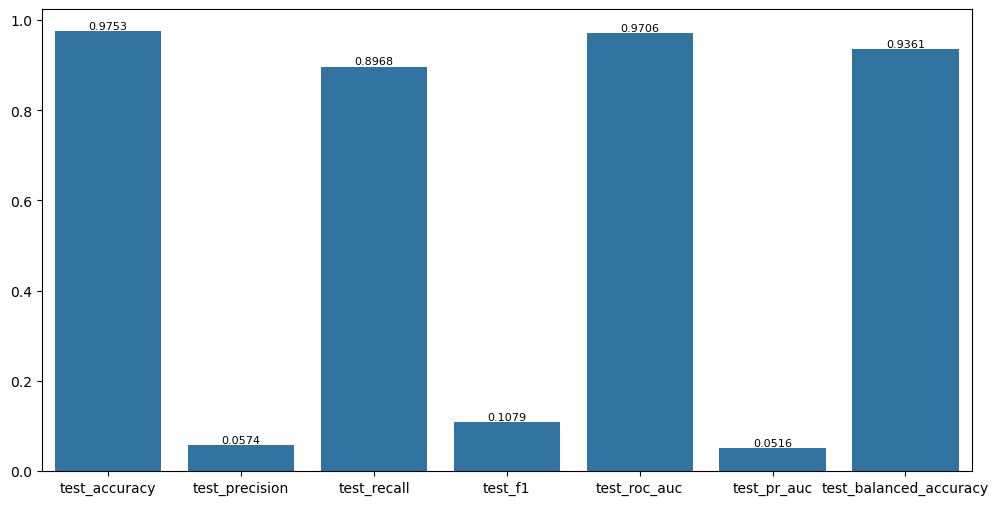

In [34]:
plt.figure(figsize=(12,6))
base_model_scores_barplot = sns.barplot(results_df.loc['test_accuracy':])


for patch in base_model_scores_barplot.patches:
    height = patch.get_height()
    if height > 0:
        base_model_scores_barplot.annotate(f'{height:.4f}',  # formatting
            (patch.get_x() + patch.get_width() / 2, height), # setting each coordinate to be on the patch
            ha='center', va='bottom', fontsize=8, rotation=0) # position related to the patch cordinate, right above and center


plt.show()